In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/case_study.csv', index_col=0, low_memory=False)
pd.set_option('display.width', 1000)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


Our main column of interest is called PHYSHLTH. It represents the number of days with bad physical health out of the past 30 days. 

In [25]:
# Display summary statistics and unique values.
print(df['PHYSHLTH'].describe())
print(df['PHYSHLTH'].unique())

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: PHYSHLTH, dtype: float64
[88.  2. 28.  5. 30.  4.  3. 77. 15. 29.  7. 10. 14.  6.  1.  8. 25. 99.
 20. 12. 18. 27. 21. 19. 22.  9. 13. 17. 11. 16. 24. 26. 23.]


Text(0.5, 1.0, 'Distribution of PHYSHLTH in Raw Data')

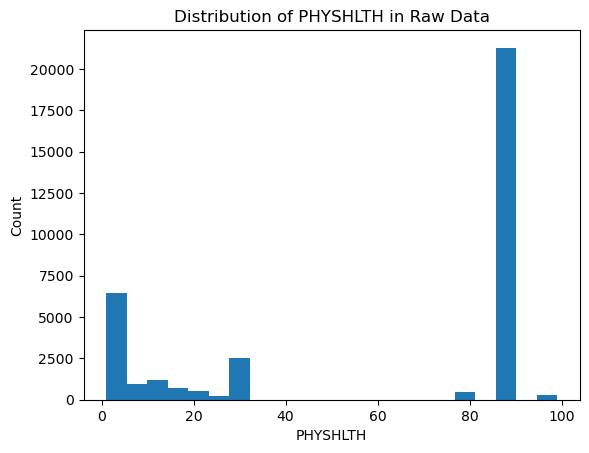

In [26]:
# Visualize the distribution of PHYSHLTH before cleaning
fig, ax = plt.subplots()
ax.hist(df["PHYSHLTH"], bins="auto")
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Raw Data")

We need to clean this column. According to the data dictionary, 88 represents None, 77 Don’t know/Not sure and 99 Refused.  
88 should be replaced with 0, 77 and 99 should be dropped. 

In [27]:
# Replace '88' in the 'PHYSHLTH' column with 0
df.loc[df['PHYSHLTH']==88, 'PHYSHLTH']=0
# Drop rows where 'PHYSHLTH' has values greater than 30 (77 and 99)
df.drop(index=df[df['PHYSHLTH']>30].index, inplace=True)

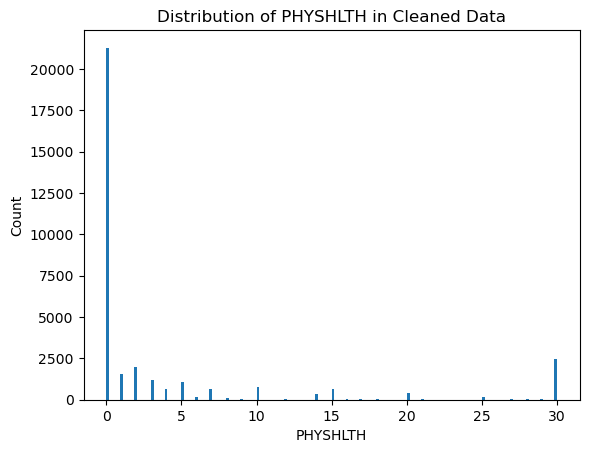

In [28]:
# Visualize the distribution of PHYSHLTH after cleaning
fig, ax = plt.subplots()
ax.hist(df["PHYSHLTH"], bins='auto')
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Cleaned Data")
plt.show()

**1. Describe the Distribution of Health Status by State**  
Here we will ivestigate whether PHYSHLTH differs by state.

The dataset we are using only includes data from three states.

In [29]:
df['_STATE'].value_counts()

_STATE
36.0    11876
34.0    11458
9.0     10413
Name: count, dtype: int64

We are going to replace the numeric state codes with their corresponding state names.

In [30]:
# Define a dictionary to map state codes to their respective state names
states_dict = {9:'Connecticut', 34:'New Jersey', 36:'New York'}
# Map the '_STATE' column in the DataFrame using the dictionary
df['_STATE'] = df['_STATE'].map(states_dict)
df['_STATE'].value_counts()

_STATE
New York       11876
New Jersey     11458
Connecticut    10413
Name: count, dtype: int64

We will visualize the distribution of PHYSHLTH by State to see if there is any visible difference. 

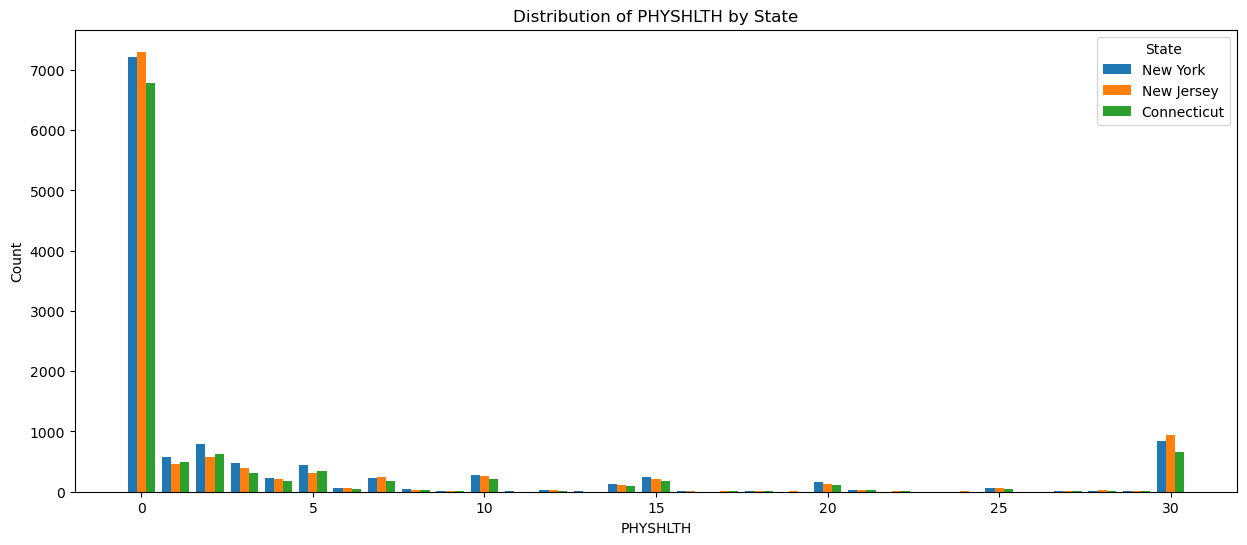

In [31]:
# Select the PHYSHLTH column for each state 
ny = df.loc[df["_STATE"] == "New York", "PHYSHLTH"]
nj = df.loc[df["_STATE"] == "New Jersey", "PHYSHLTH"]
ct = df.loc[df["_STATE"] == "Connecticut", "PHYSHLTH"]

fig, ax = plt.subplots(figsize=(15, 6))

# Plot histograms for each state's 'PHYSHLTH' data on the same axes
ax.hist(x=[ny, nj, ct], label=["New York", "New Jersey", "Connecticut"], bins=range(32), align="left")

ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH by State")

ax.legend(title="State");
plt.show()

In [32]:
# Calculate the mean PHYSHLTH for each state
df.groupby('_STATE')['PHYSHLTH'].mean()

_STATE
Connecticut    3.688562
New Jersey     4.380957
New York       4.148030
Name: PHYSHLTH, dtype: float64

The means are quite different, but we need to determine if this is statistically significant.

To determine which test to use, we need to check the nature of our data. Particularly whether the data is normally distributed and whether variances are equal.  
To check for normality we will use the Kolmogorov-Smirnov Test

In [33]:
from scipy.stats import kstest

dict = {'New York':ny, 'New Jersey':nj, 'Connecticut':ct}
# Perform the Kolmogorov-Smirnov test on each state's data to check if it follows a normal distribution
for name, state in dict.items():
    stat, p_value = kstest(state, 'norm', args=(state.mean(), state.std()))
    print(f"{name}: p-value = {p_value}")
    if p_value < 0.05:
        print("Data is not normally distributed.")
    else:
        print("Data is normally distributed.")

New York: p-value = 0.0
Data is not normally distributed.
New Jersey: p-value = 0.0
Data is not normally distributed.
Connecticut: p-value = 0.0
Data is not normally distributed.


The PHYSHLTH data for each state significantly deviates from a normal distribution.

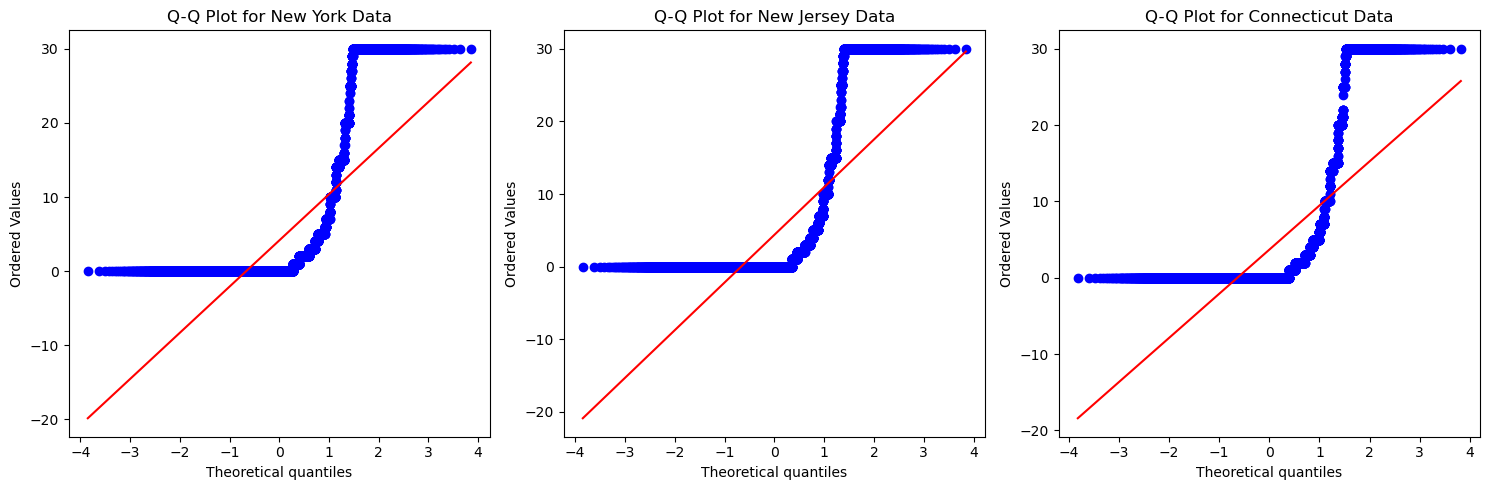

In [34]:
import scipy.stats as stats

# Create Q-Q plots to compare the observed data to a theoretical normal distribution.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, state) in enumerate(dict.items()):
    stats.probplot(state, dist="norm", plot=ax[i])
    ax[i].set_title(f"Q-Q Plot for {name} Data")

plt.tight_layout()
plt.show()

All three plots form an s-shape. This indicates the presence of skewness and heavy tails.  
This confirms our findings from the Kolmogorov-Smirnov Test that the data deviates significantly from a normal distribution.

We also need to check whether the variances across the three states are equal. To do this, we need to perform a Leven's test.

In [35]:
from scipy.stats import levene

# Perform Levene's test for equality of variances between the three states
stat, p_value = levene(ny, nj, ct)
print(f"Levene's Test: p-value = {p_value}")
if p_value < 0.05:
    print("Variances are not equal.")
else:
    print("Variances are equal.")

Levene's Test: p-value = 8.800607044147037e-09
Variances are not equal.


The result indicates that the variances across the three groups are not equal.

Since the data does not follow a normal distribution, and the variances are unequal, we cannot use parametric tests such as ANOVA, which assume normality and homogeneity of variances.  
We will use the Kruskal-Wallis test, a non-parametric method used to determine if there are statistically significant differences between two or more groups.  
  
For this test:  
> Null Hypothesis: There is no difference in physical health across the three states.  
> Alternative Hypothesis: There is a difference in physical health across the three states.  
> Significance level is 0.05.

In [36]:
# Use the pingouin library for tests 
import pingouin as pg
# Apply the Kruskal-Wallis test to compare 'PHYSHLTH' across the three states.
result = pg.kruskal(data=df, dv='PHYSHLTH', between='_STATE')
print(result)

         Source  ddof1          H         p-unc
Kruskal  _STATE      2  43.378278  3.806507e-10


Perform pairwise comparisons to identify which specific states differ from each other

In [37]:
# Perform pairwise comparisons
posthoc = pg.pairwise_tests(data=df, dv='PHYSHLTH', between='_STATE', parametric=False, padjust='bonferroni')
print(posthoc)

  Contrast            A           B  Paired  Parametric       U-val alternative         p-unc        p-corr    p-adjust    hedges
0   _STATE  Connecticut  New Jersey   False       False  58208589.5   two-sided  2.865924e-04  8.597772e-04  bonferroni -0.081044
1   _STATE  Connecticut    New York   False       False  59073037.0   two-sided  3.133961e-11  9.401882e-11  bonferroni -0.055439
2   _STATE   New Jersey    New York   False       False  66752688.0   two-sided  4.125605e-03  1.237682e-02  bonferroni  0.026823


The p values indicate significant differences in PHYSHLTH across all state pairs.  

**2. Describe the Relationship between Health Status and Home Ownership Status**  
Here we will investigate whether home ownership status affects physical health.

The column of interest here is 'RENTHOM1'.  
The possible values are as follows:  
1: Own  
2: Rent  
3: Other arrangement  
7: Don’t know/Not sure  
9: Refused  

In [38]:
df["RENTHOM1"].value_counts()

RENTHOM1
1.0    21690
2.0    10244
3.0     1526
9.0      194
7.0       93
Name: count, dtype: int64

We need to drop all records where the RENTHOM1 value label is neither Own nor Rent and replace the numeric codes with 'Own' and 'Rent' respectively.  

In [40]:
# Create a dictionary to map numeric values in the 'RENTHOM1' column to respective labels.
renting_dict = {1:'Own', 2:'Rent'}

# Create a copy of the original dataframe to work on housing-related analysis without modifying the original data
df_renting_copy = df.copy()
# Map column values with labels
df_renting_copy['RENTHOM1'] = df_renting_copy['RENTHOM1'].map(renting_dict)
# Filter the dataframe to retain only rows where 'RENTHOM1' is either 'Own' or 'Rent' 
df_renting_copy = df_renting_copy[df_renting_copy['RENTHOM1'].isin(['Own', 'Rent'])]
df_renting_copy['RENTHOM1'].value_counts()

RENTHOM1
Own     21690
Rent    10244
Name: count, dtype: int64

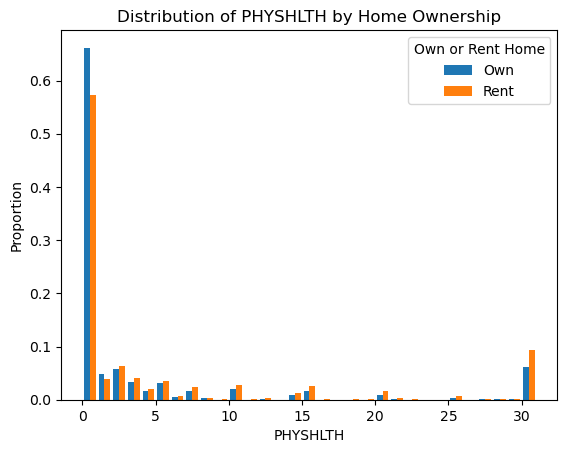

In [41]:
# Visualize the distribution of PHYSHLTH across home ownership status

# Select the PHYSHLTH column for owners and renters.
owners = df_renting_copy.loc[df_renting_copy['RENTHOM1']=='Own', 'PHYSHLTH']
renters = df_renting_copy.loc[df_renting_copy['RENTHOM1']=='Rent', 'PHYSHLTH']

fig, ax = plt.subplots()
# Plot histograms for owners and renters on the same plot 
ax.hist(x=[owners,renters], label=["Own", "Rent"], density=True, bins=range(32))
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Proportion")
ax.set_title("Distribution of PHYSHLTH by Home Ownership")
ax.legend(title="Own or Rent Home")
plt.show()

In [42]:
# Calculate the mean value of 'PHYSHLTH' for each group
df_renting_copy.groupby("RENTHOM1")["PHYSHLTH"].mean()

RENTHOM1
Own     3.531213
Rent    5.197970
Name: PHYSHLTH, dtype: float64

On average, renters experience more physically unwell days compared to owners. We need to run tests to determine if this difference is statistically significant.

To determine which test to use, we need to check the nature of our data. Particularly whether the data is normally distributed and whether variances are equal.  
To check for normality we will use the Kolmogorov-Smirnov Test

In [43]:
dict = {'Owners':owners, 'Renters':renters}

# For each group, perform the Kolmogorov-Smirnov test to compare the data distribution against a normal distribution.
for name, state in dict.items():
    stat, p_value = kstest(state, 'norm', args=(state.mean(), state.std()))
    print(f"Kolmogorov-Smirnov Test for {name}: p-value = {p_value}")
    if p_value < 0.05:
        print("Data is not normally distributed.")
    else:
        print("Data is normally distributed.")

Kolmogorov-Smirnov Test for Owners: p-value = 0.0
Data is not normally distributed.
Kolmogorov-Smirnov Test for Renters: p-value = 0.0
Data is not normally distributed.


Both groups deviate significantly from a normal distribution.

We'll use the Levene's test to check for equality of variances.

In [44]:
# Perform Levene's test to check for equality of variances
stat, p_value = levene(owners, renters)
print(f"Levene's Test: p-value = {p_value}")
if p_value < 0.05:
    print("Variances are not equal.")
else:
    print("Variances are equal.")

Levene's Test: p-value = 1.8788392563312983e-60
Variances are not equal.


Given that:

> The data is not normally distributed.  
> The variances are not equal.  
> 
A Mann-Whitney U test is appropriate for comparing PHYSHLTH between Owners and Renters. This non-parametric test does not assume normality or equal variances, making it suitable for the data characteristics.

For this test:
> Null Hypothesis: PHYSHLTH is the same between Owners and renters.  
> Alternative Hypothesis: PHYSHLTH in renters is higher than in owners.  
> Significance level = 0.05

In [45]:
# Perform the Mann-Whitney U test to compare PHYSHLTH between Owners and Renters.
result = pg.mwu(owners, renters, alternative='less')
print(result)

          U-val alternative         p-val      RBC     CLES
MWU  99493298.0        less  1.076356e-68 -0.10444  0.55222


The p-value is significantly small. We therefore reject the null hypothesis and adopt the alternative which states that Owners have significantly better health than renters.

**3.Describe the Relationship between Chronic Sickness and Nicotine Use**  
Here we will investigate whether Nicotine use leads to chronic sickness.

We define nicotine use as:  
1. Answered Yes to the SMOKE100 question (Have you smoked at least 100 cigarettes in your entire life?), OR  
2. Answered Every day or Some days to the USENOW3 question (Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?), OR  
3. Answered Yes to the ECIGARET question (Have you ever used an e-cigarette or other electronic vaping product, even just one time, in your entire life?)

In [46]:
# Create a new column NICOTINE_USE and set everything to 0 initially.
df['NICOTINE_USE'] = 0
# If a record matches one or more of the above criteria, NICOTINE_USE should be 1.
df.loc[(df['SMOKE100']==1)|(df['USENOW3'].isin([1,2]))|(df['ECIGARET']==1), 'NICOTINE_USE'] = 1
df["NICOTINE_USE"].value_counts(normalize=True)

NICOTINE_USE
0    0.564761
1    0.435239
Name: proportion, dtype: float64

Let's treat health status as a categorical variable. To keep things simple, we'll say that a "chronically sick" person is a person who reports that their physical health was not good for 15 or more out of the past 30 days.

In [47]:
# Create a new column CHRONIC and set everything to 0 initially.
df['CHRONIC'] = 0
# If a person reports that their physical health was not good for 15 or more out of the past 30 days, set CHRONIC to 1.
df.loc[df['PHYSHLTH']>=15, 'CHRONIC'] = 1

df['CHRONIC'].value_counts()

CHRONIC
0    29834
1     3913
Name: count, dtype: int64

In [48]:
# Create a contingency table to examine the relationship between chronic illness (CHRONIC) and nicotine use (NICOTINE_USE)
contingency_table = pd.crosstab(index=df["CHRONIC"], columns=df["NICOTINE_USE"])
print(contingency_table)

NICOTINE_USE      0      1
CHRONIC                   
0             17312  12522
1              1747   2166


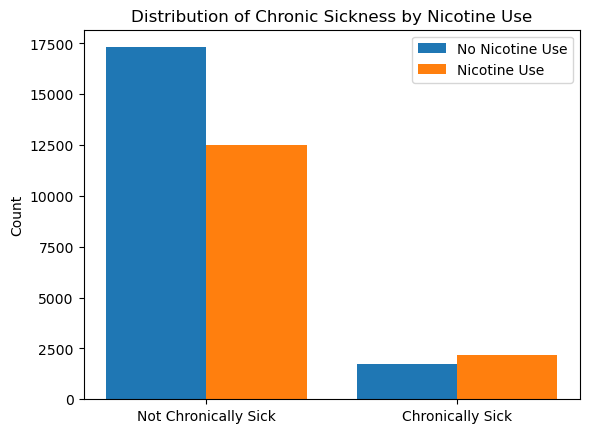

In [49]:
# Visualize the prevalence of chronic illness between individuals who use nicotine and those who do not.

# Select the CHRONIC column for nicotine users and non users.
no_nicotine_use = df.loc[df["NICOTINE_USE"] == 0, "CHRONIC"]
nicotine_use = df.loc[df["NICOTINE_USE"] == 1, "CHRONIC"]

fig, ax = plt.subplots()
# Plot histograms for users and non users on the same plot.
ax.hist(x=[no_nicotine_use, nicotine_use], label=["No Nicotine Use", "Nicotine Use"], bins=[0,1,2], align="left")

ax.set_ylabel("Count")
ax.set_xticks([0,1])
ax.set_xticklabels(["Not Chronically Sick", "Chronically Sick"])
ax.set_title("Distribution of Chronic Sickness by Nicotine Use")

ax.legend()
plt.show()

The plot and contingency table show that a higher proportion of chronically sick individuals use nicotine. To investigate this further we need to run statistical tests.

Given that we are dealing with categorical variables, we need to run a chi-squared test.  
For this test:  
> Null Hypothesis: There is no association between nicotine use and chronic illness.
> Alternative Hypothesis: There is an association between nicotine use and chronic illness.  
> Significance level = 0.05

In [50]:
# Perform a Chi-Square test of independence to determine whether there is a statistically significant association between the variables CHRONIC and NICOTINE_USE.
result = stats.chi2_contingency(contingency_table)
print(result)

Chi2ContingencyResult(statistic=251.4651163595463, pvalue=1.2446142252618191e-56, dof=1, expected_freq=array([[16849.08898569, 12984.91101431],
       [ 2209.91101431,  1703.08898569]]))


The p-value is significantly small. We therefore adopt the alternative hypothesis which states that there is an association between nicotine use and chronic illness.